In [2]:
cd
build_path niak psom
cd /home/pbellec/git/niak_tutorials/glm_connectome

Adding library niak to the search path.

Adding library psom to the search path.



# GLM connectome pipeline - intra-run
This tutorial shows how to use the NIAK GLM connectome pipeline to compare two groups of subjects, 10 patients diagnosed with schizophrenia vs 10 healthy controls. We will illustrate how to include an intra-run contrast, i.e. manipulate the fMRI time series of each subject prior to generate connectivity measures. See the [documentation](http://niak.simexp-lab.org/pipe_glm_connectome.html) of the pipeline for a more detailed description of the options. There is also inline documentation you can access by typing `help niak_pipeline_glm_connectome`. Download the tutorial as a notebook [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/glm_connectome/niak_tutorial_glm_connectome_cobre.ipynb) and a matlab script [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/connectome/niak_tutorial_glm_connectome_cobre.m). To run this tutorial, we recommend to use [jupyter](http://jupyter.org/) from a niak docker container, as described in the [NIAK installation page](http://niak.simexp-lab.org/niak_installation.html). 

# Preparing the files
### Functional MRI 
First download a small preprocessed fMRI dataset. 

In [3]:
clear
path_data = [pwd filesep];
[status,msg,data_fmri] = niak_wget('cobre_lightweight20_nii');

When starting from fMRI data preprocessed with NIAK, it is possible to use `niak_grab_fmri_preprocess` on the output folder to collect the file names, as described in the [pipeline documentation](http://niak.simexp-lab.org/pipe_connectome.html). In this case, we explicitely list all the files

In [4]:
file_pheno = [data_fmri.path filesep 'phenotypic_data.tsv.gz'];
tab = niak_read_csv_cell(file_pheno);
list_subject = tab(2:end,1);
files_in = struct;
for ss = 1:length(list_subject)
    files_in.fmri.(list_subject{ss}).sess1.rest = [data_fmri.path filesep 'fmri_' list_subject{ss} '.nii.gz'];
end

### Brain parcellation
The second input of the pipeline is a set of brain parcels. We will just download the so-called Cambridge functional template.

In [5]:
[status,msg,data_template] = niak_wget('cambridge_template_mnc1');

We are going to pick the parcellation into 36 clusters.

In [6]:
files_in.network = [data_template.path filesep 'template_cambridge_basc_multiscale_sym_scale007.mnc.gz'];

## Group model

We need to build a group model describing our explanatory variables. We will start from an existing spreadsheet, saved in the `.csv` file format, and is available in the COBRE sample. 

In [7]:
path_cobre = [pwd filesep 'cobre_lightweight20'];
file_pheno = [path_cobre filesep 'phenotypic_data.tsv.gz'];
tab = niak_read_csv_cell(file_pheno);

Now we convert the values into a series of numerical covariates, that we save in a separate .csv file:

In [8]:
list_subject = tab(2:end,1);
patient = strcmp(tab(2:end,5),'Patient');
age = str2double(tab(2:end,2)); 
FD = str2double(tab(2:end,9));
opt_csv.labels_x = list_subject; % Labels for the rows
opt_csv.labels_y = { 'age' , 'patient' , 'fd' };
niak_write_csv('model_patient.csv', [age patient FD] , opt_csv);

We specify to the pipeline where to find the model:

In [9]:
files_in.model.group = [pwd filesep 'model_patient.csv'];

### Checking the group model

Although not necessary, we can visualize the group model and make sure it can be loaded properly with NIAK. The model is loaded in three variables:

In [10]:
[X_group,list_subject,list_var] = niak_read_csv(files_in.model.group);

The `list_subject` and `list_var` are cell of strings that describe the subject (row) labels, and explanatory variables (column) labels, respectively: 

In [11]:
list_subject(1:3)
list_var

ans = 
{
  [1,1] = 40061
  [2,1] = 40117
  [3,1] = 40145
}
list_var = 
{
  [1,1] = age
  [2,1] = patient
  [3,1] = fd
}


Here we have three variables: `age` is self-explanatory, `patient` is a binary variable coding for the diagnostic status (0 for controls, 1 for patients), and `fd` is an overall measure of motion during the fMRI scan, called frame displacement. We can visualize the data associated with the three variables as follows: We can compute the correlation between our three explanatory variables:

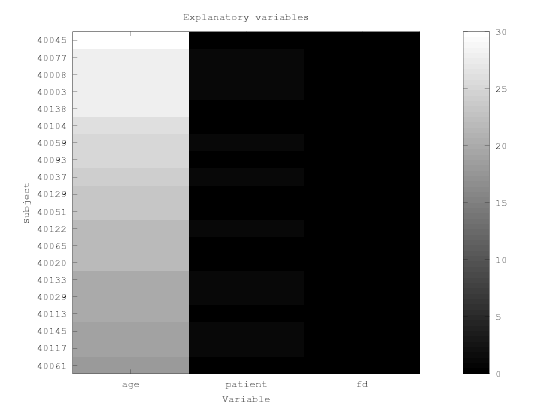

In [23]:
figure
% That is making the figure
imagesc(X_group)
% Set title for figure and axes
title('Explanatory variables')
xlabel('Variable')
ylabel('Subject')
% Set subject and variable labels on each axis
ha = gca;
set(ha,'xtick',1:length(list_var))
set(ha,'ytick',1:length(list_subject))
set(ha,'xticklabel',list_var)
set(ha,'yticklabel',list_subject)
% Add a colorbar and a gray colormap
colormap gray
colorbar

It is hard to visualize because our variables have vastly different ranges. For visualization purposes, we can normalize our variables to have a zero mean and unit variance

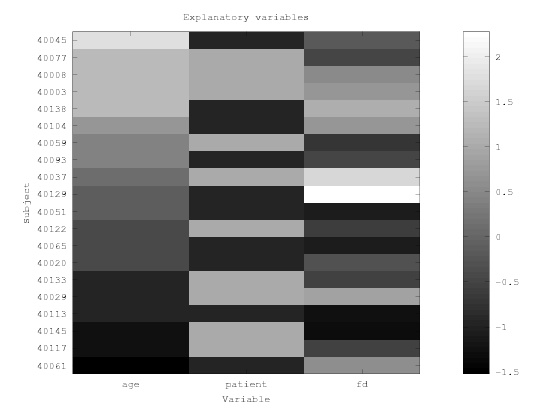

In [24]:
figure
% That is making the figure
% Note the call to niak_normalize_tseries to correct each variable to zero mean/unit variance
imagesc(niak_normalize_tseries(X_group))
% Set title for figure and axes
title('Explanatory variables')
xlabel('Variable')
ylabel('Subject')
% Set subject and variable labels on each axis
ha = gca;
set(ha,'xtick',1:length(list_var))
set(ha,'ytick',1:length(list_subject))
set(ha,'xticklabel',list_var)
set(ha,'yticklabel',list_subject)
% Add a colorbar and a gray colormap
colormap gray
colorbar

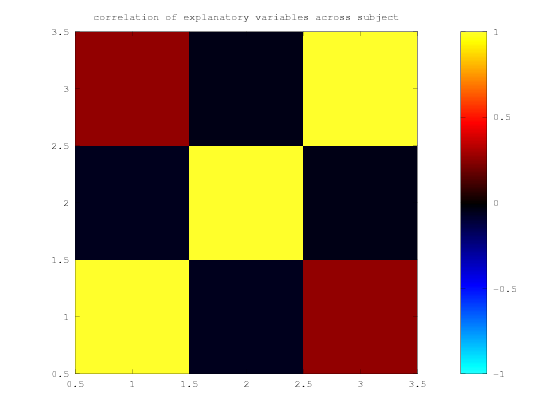

In [26]:
Rx = corr(X_group);
niak_visu_matrix(Rx);
title('correlation of explanatory variables across subject')

# Connectivity maps

Now we are going to get a list of the connectivity maps associated with each subject for one network, say the DMN. Labels for each network have been specified when running the `connectome` pipeline. We simply grab the outputs of the connectome pipeline. 

In [ ]:
path_connectome = [pwd filesep 'connectome'];
files_conn = niak_grab_connectome(path_connectome);
files_in.data = files_conn.rmap;

## Brain mask
We specify the mask of brain networks to the pipeline, so that it can use it to mask the grey matter. 

In [ ]:
files_in.mask = files_conn.network_rois;

# Set up the options of the pipeline

First specify where to save the outputs, and how many networks to use: 

In [ ]:
%% General
opt.folder_out = [pwd filesep 'subtype'];    

Then specify which covariates to use as confounds **before** the generation of subtypes. 

In [ ]:
% a list of variable names to be regressed out
% If unspecified or left empty, no confounds are regressed
opt.stack.regress_conf = {'fd'};     

The options for the subtypes themselves:

In [ ]:
%% Subtyping
opt.subtype.nb_subtype = 2;        % the number of subtypes to extract
opt.subtype.sub_map_type = 'mean'; % the model for the subtype maps (options are 'mean' or 'median')

Now we add an association test between subtypes and the patient label:

In [ ]:
% scalar number for the level of acceptable false-discovery rate (FDR) for the t-maps
opt.association.patient.fdr = 0.05;                           
% turn on/off normalization of covariates in model (true: apply / false: don't apply)
opt.association.patient.normalize_x = false;                   
% turn on/off normalization of all data (true: apply / false: don't apply)
opt.association.patient.normalize_y = false;                  
% turn on/off adding a constant covariate to the model
opt.association.patient.flag_intercept = true;     
% To test a main effect of a variable
opt.association.patient.contrast.patient = 1; % scalar number for the weight of the variable in the contrast
opt.association.patient.contrast.fd = 0;      % scalar number for the weight of the variable in the contrast
opt.association.patient.contrast.age = 0;     % scalar number for the weight of the variable in the contrast
% type of data for visulization (options are 'continuous' or 'categorical')
opt.association.patient.type_visu = 'continuous'; 

It is also possible to add a single chi-square test on the relationship between subtypes and a categorical variable:

In [ ]:
% string name of the column in files_in.model on which the contigency table will be based
opt.chi2 = 'patient';    

# Run the pipeline

In [ ]:
opt.flag_test = false;  % Put this flag to true to just generate the pipeline without running it.
pipeline = niak_pipeline_subtype(files_in,opt);